- Utilizaremos una serie temporal sobre ventas de peces y gatos en miles de libras, con frecuencia de muestreo mensual.

- Realizaremos un primer análisis gráfico de la serie y obtendremos algunos estadísticos asociados a la misma.

- Se procederá a una descomposición de la serie en componentes de tendencia, estacional y residual.

- Aplicaremos el test ACF para comprobar la estacionaridad de la serie.
En caso de ser no estacionaria, aplicaremos algunas de las técnicas vistas en clase (por ejemplo, diferenciación).

- Representaremos los gráficos de autocorrelación y autocorrelación parcial.
Una vez preprocesada, modelaremos la serie usando ARMA y SARIMA.
Probaremos a utilizar el modelo SARIMA para predecir.

# Descarga del dataset

In [1]:
import pandas as pd
# Leemos el dataset de catfish.csv

df = pd.read_csv('catfish.csv')
df.head()


,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


In [2]:
# Convertimos 'Date' a datetime y extraemos año y mes
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Reordenamos columnas: Year, Month, luego todas las demás menos 'Total', y 'Total' al final
other_cols = [col for col in df.columns if col not in ['Year', 'Month', 'Total']]
df = df[['Year', 'Month'] + other_cols + ['Total']]

df.head()

,Year,Month,Date,Total
0,1986,1,1986-01-01,9034
1,1986,2,1986-02-01,9596
2,1986,3,1986-03-01,10558
3,1986,4,1986-04-01,9002
4,1986,5,1986-05-01,9239


## Primer análisis gráfico

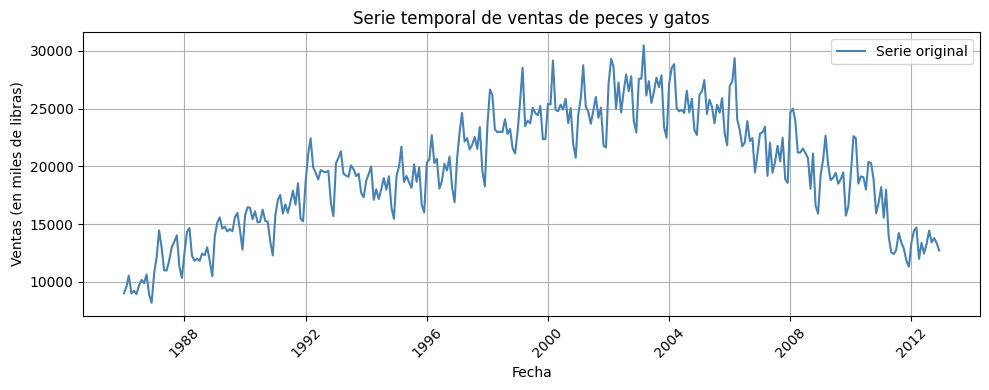

In [3]:
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)       # Convierte la fecha en el índice

# Gráfico de la serie
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['Total'], label='Serie original', color='steelblue')
plt.title('Serie temporal de ventas de peces y gatos')
plt.xlabel('Fecha')
plt.ylabel('Ventas (en miles de libras)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Media deslizante

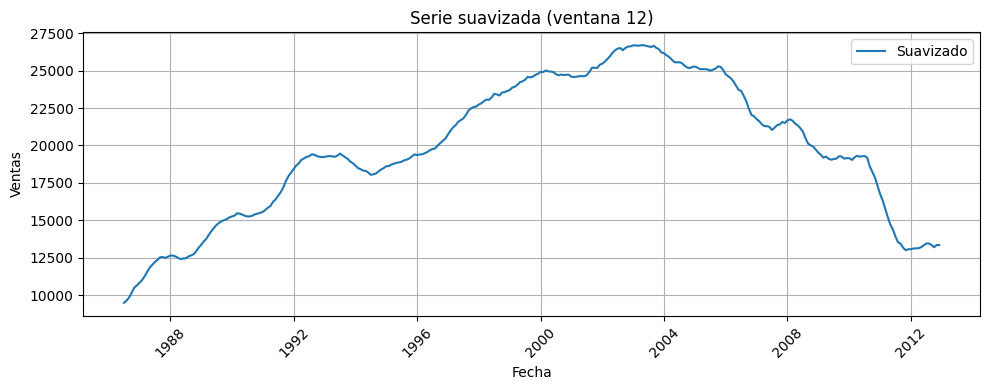

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que df tiene el índice como DateTimeIndex
x = df['Total'].values
dates = df.index

win = 12
win_half = int(win / 2)

# Suavizado
total_smooth = np.array([x[(idx - win_half):(idx + win_half)].mean() for idx in np.arange(win_half, len(x))])

# Ajustamos las fechas para que coincidan con total_smooth
smooth_dates = dates[win_half:len(x)]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(smooth_dates, total_smooth, label='Suavizado')
plt.title('Serie suavizada (ventana 12)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 1000x400 with 0 Axes>

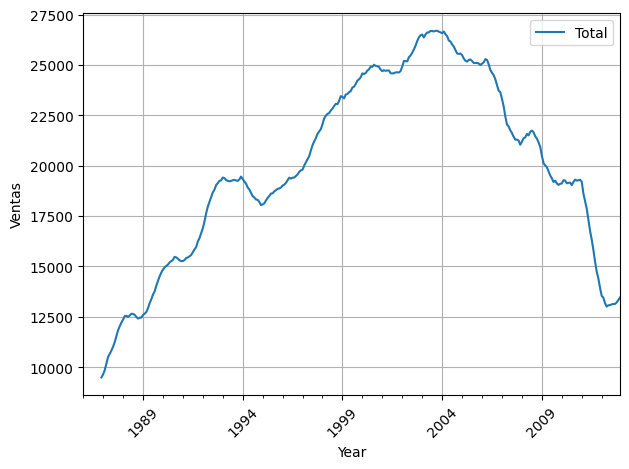

In [5]:
total = df['Total']

df_avg = pd.concat([total.rolling(12).mean()], axis=1)
plt.figure(figsize=(10, 4))
df_avg.plot()
plt.xlabel('Year')
plt.ylabel('Ventas')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Comprobar estacionariedad

In [6]:
### Representar los estadísticos para comprobar la estacionariedad
def test_stationarity(timeseries, title):

    # Determinar los estadísticos
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='media deslizante');
    ax.plot(rolstd, label='desviación típica deslizante (x10)');
    ax.legend()

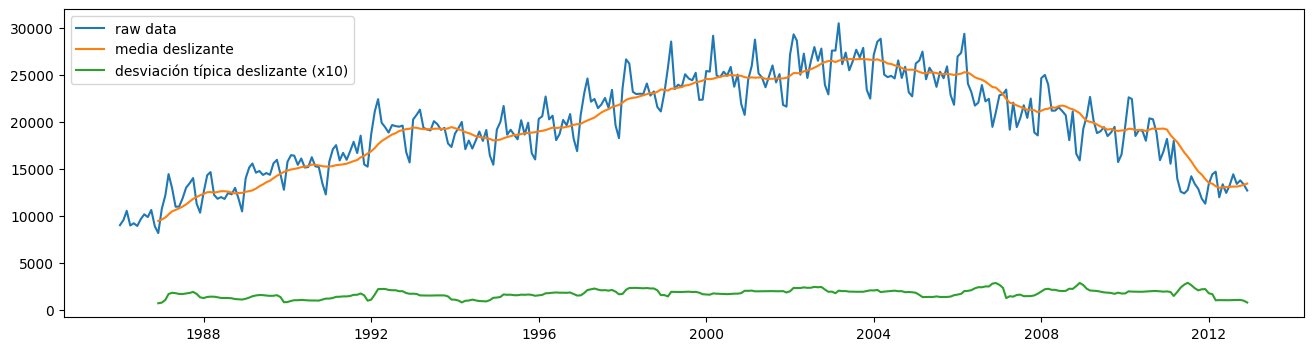

In [7]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df["Total"],'raw data')

### Test estadístico Augmented Dickey-Fuller (ADF)


In [8]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > ¿Es estacionaria la serie {}?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Estadístico = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Valores críticos :')
    for k, v in dftest[4].items():
        print('\t{}: {} - La serie es {} estacionaria con una confianza de {}%'.format(k, v, 'no' if v<dftest[0] else '', 100-int(k[:-1])))

In [9]:
ADF_test(df["Total"],'Datos originales')

 > ¿Es estacionaria la serie Datos originales?
Estadístico = -1.590
P-value = 0.489
Valores críticos :
	1%: -3.45169128009473 - La serie es no estacionaria con una confianza de 99%
	5%: -2.8709394227049154 - La serie es no estacionaria con una confianza de 95%
	10%: -2.5717780602423517 - La serie es no estacionaria con una confianza de 90%


Intentamos hacer la serie estacionaria restándole la media deslizante

 > ¿Es estacionaria la serie 12 lag differenced de-trended data?
Estadístico = -5.588
P-value = 0.000
Valores críticos :
	1%: -3.4535050041524245 - La serie es  estacionaria con una confianza de 99%
	5%: -2.8717352599720294 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5722024776854417 - La serie es  estacionaria con una confianza de 90%


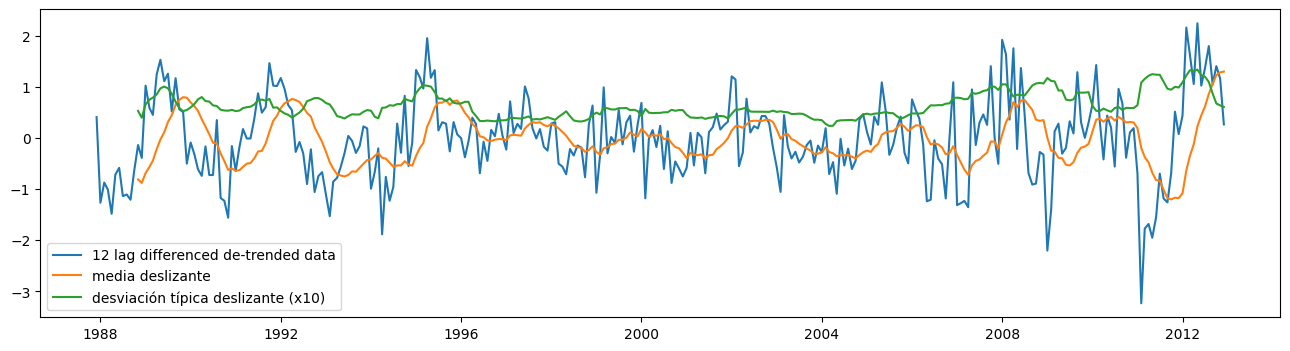

In [10]:
# Eliminar tendencia
data_detrend =  (df["Total"] - df["Total"].rolling(window=12).mean())/df["Total"].rolling(window=12).std()

# Eliminar tendencia y diferenciar

data_12lag_detrend =  data_detrend - data_detrend.shift(12)

test_stationarity(data_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(data_12lag_detrend,'12 lag differenced de-trended data')

## Autocorrelación

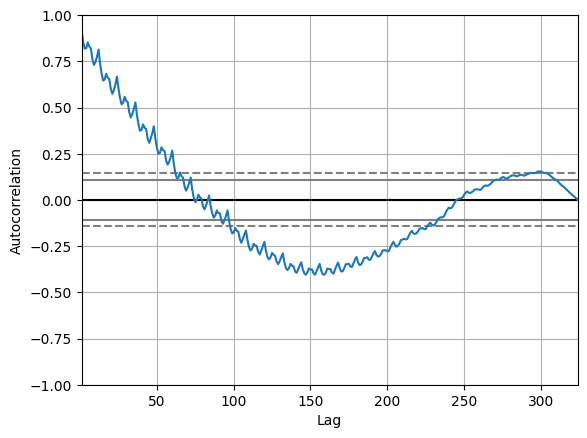

In [11]:
from pandas.plotting import autocorrelation_plot

x = df["Total"].astype(float)
autocorrelation_plot(x);

## Autocorrelación y Autocorrelación Parcial

Una ST se dice que es periódica si se repite en intervalos equiespaciados en el tiempo, por ejemplo, cada 12 meses.

La función de autocorrelación (ACF) es una medida de la correlación entre la ST con una versión retardada de la misma. Por ejemplo, si tomamos lag=5, ACF compararía los instantes t6, t7, t8... de la ST con t1, t2, t3...

La función de autocorrelación parcial (PACF) mide la correlación entre la ST en una versión retardada de sí misma pero eliminando antes la varianza ya explicada por retardos anteriores. Por ejemplo, si medimos el PACF para un $lag=5$ tendremos en cuenta la correlación con los valores de la serie de hace 5 instantes de tiempo, pero eliminando la varianza ya explicada por los restardos 1, 2, 3 y 4.

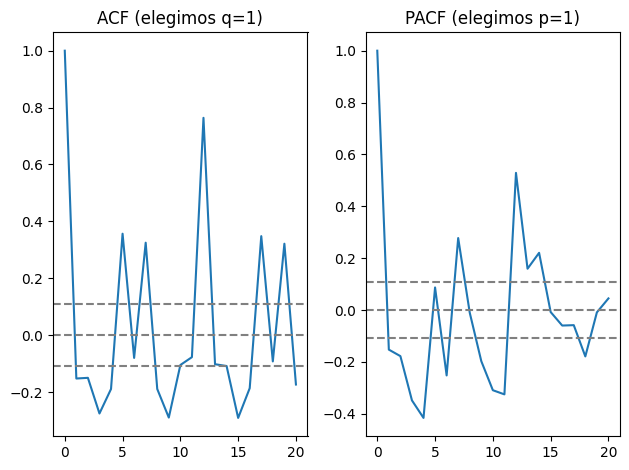

In [12]:
from statsmodels.tsa.stattools import acf, pacf

x_diff = x.diff().dropna() # El primer término será NA

# Valores ACF y PACF:
lag_acf = acf(x_diff, nlags=20, fft=True)
lag_pacf = pacf(x_diff, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('ACF (elegimos q=1)')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('PACF (elegimos p=1)')
plt.tight_layout()

Vemos una clara estacionalidad en los datos. Tiene picos cada 12 meses,lo que puede indicar que la venta de gatos y peces siguen una tendencia todos los años.

## División en conjunto de entrenamiento y test

Dividiremos el conjunto de datos a partir del 2009, es decir, los datos anteriores a 2009 serán nuestro conjunto de entrenamiento, mientras que los posteriores serán nuestro conjunto de test.

In [13]:
predict_date='2009-01-01'
data_to_train = df[:predict_date]["Total"] # Datos de entrenamiento (todos los años salvo los dos últimos)
data_to_test = df[predict_date:]["Total"] # Dos últimos años para test
predict_length = len(df) - len(df[:predict_date]) # Número de datos en test

In [14]:
data_to_test.head()

,Total
Date,
2009-01-01,19262
2009-02-01,20658
2009-03-01,22660
2009-04-01,20147
2009-05-01,18818


## Modelo ARMA

Mientras que los modelos de suavización exponencial utilizan medias ponderadas de observaciones pasadas para predecir nuevos valores, los modelos de AR y MA tienen en cuenta las autocorrelaciones o las correlaciones de serie temporal. En otras palabras, los modelos ARMA examinan las diferencias entre los valores de las series temporales.

Los modelos ARMA se suelen utilizar a menudo como herramienta para predecir valores de un ST.
Estos modelos combinan una parte AutoRegresiva (AR) con una parte de medias móviles (Moving Average, MA).
En los modelos MA, asumimos que una variable es la suma de la media de la serie temporal y una combinación lineal de componentes de ruido.

Los modelos AR y MA pueden tener distinto orden. En general, podemos definir un modelo ARMA con $p$ términos autorregresivos y $q$ términos de medias móviles de la siguiente forma:

$$
X_t = \sum_i^p \phi_i X_{t-i} +\sum_i^q \theta_i a_{t-i} + a_t
$$

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  324
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2903.249
Date:                Thu, 17 Apr 2025   AIC                           5814.498
Time:                        10:31:03   BIC                           5829.621
Sample:                    01-01-1986   HQIC                          5820.534
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.964e+04   3801.809      5.167      0.000    1.22e+04    2.71e+04
ar.L1          0.9931      0.008    132.004      0.000       0.978       1.008
ma.L1         -0.6149      0.042    -14.691      0.0

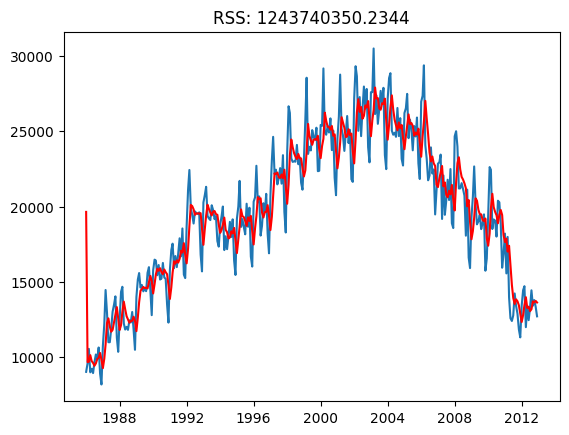

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Modelo más general Seasonal ARIMA multiplicativo SARIMAX(p,d,q)x(P,D,Q,s)
# order=(p,d,q) seasonal_order(P,D,Q,s)
model = ARIMA(x, order=(1, 0, 1), seasonal_order=(0,0,0,0)).fit() # fit model

print(model.summary())
plt.plot(x)
plt.plot(model.predict(), color='red')
plt.title('RSS: %.4f'% sum((model.fittedvalues-x)**2));

## Modelo SARIMA

Adecuados para datos de series temporales con componentes de tendencia y/o estacionales.

SARIMA se basa en el concepto de ARIMA pero lo amplía para modelar las componentes estacionales de los datos. Observaréis que SARIMA incluye varios parámetros que pueden ajustarse para lograr un rendimiento óptimo. Podéis obtener más información sobre estos parámetros [aquí](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/). Son los siguientes:
- Elementos de tendencia:

   - $p$: Orden de autoregresión de tendencia.
   - $d$: Orden de diferencia de tendencia.
   - $q$: Orden de media móvil de tendencia.

- Elementos estacionales:
   - $P$: Orden de autorregresión estacional.
   - $D$: Orden de diferencia estacional.
   - $Q$: Orden de media móvil estacional.

- $s$: Periodo para la parte estacional.

Para obtener la mejor predicción, es importante encontrar los valores de $SARIMA(p,d,q)(P,D,Q)s$ que optimicen una métrica de interés. Para los propósitos de este tutorial, utilizaremos una "búsqueda en cuadrícula" para explorar iterativamente diferentes combinaciones de parámetros.

La métrica de evaluación que utilizaremos para la búsqueda en la cuadrícula es el valor AIC (Criterio de Información de Akaike). El AIC mide lo bien que un modelo se ajusta a los datos teniendo en cuenta la complejidad general del modelo. En general, queremos elegir la combinación con el valor AIC más bajo.

In [16]:
import itertools
import statsmodels.api as sm
import warnings

# Ignoramos los warnings
warnings.filterwarnings("ignore")

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

    mini = float('+inf')


    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit(disp=False)

                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

                print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                print(param)
                print(param_seasonal)
                continue
    print('El conjunto de parámetros con mínimo AIC es: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [17]:
sarima_grid_search(data_to_train,12)

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:6275.06326458427
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:5833.411284068516
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:4713.240140142655
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:4482.724909822587
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:4726.346560789427
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:4699.146454231028
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:4499.819765954433
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:4451.7577027603475
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:6058.106488479481
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:5746.1263234462
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:4562.652963657649
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:4346.494637743115
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:4598.684736186877
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:4564.334612755487
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:4380.4013051943
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:4346.682728758613
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:4959.261606201868
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:4614.707318128043
SARIMA(0, 1, 0)x(0, 1, 0, 12) - 

In [18]:
# Llamar a esta función después de obtener la mejor combinación de parámetros en función del AIC
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # Entrenar el modelo
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])

    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

    # El argumento dynamic=False asegura que realizamos predicciones a un instante de tiempo,
    # de manera que para cada punto usamos todas las observaciones disponibles hasta ese punto.
    # Con dynamic=Fecha las predicciones de la fase de test se construyen en base a las propias
    # predicciones del modelo (no en base a los valores observados)
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('El RMSE de un modelo SARIMA con season_length={} y dynamic = False es {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observado')
    y_forecasted.plot(ax=ax, label='Predicciones en base a valores observados', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Trend')
    plt.legend()
    plt.show()

    # Una mejor idea de la capacidad predictiva puede obtenerse usando predicciones dinámicas.
    # En este caso solo usamos las observaciones hasta un determinado instante temporal y
    # después las predicciones se generan a partir de predicciones pasadas.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('El RMSE de un modelo SARIMA con season_length={} y dynamic = True es {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observado')
    y_forecasted_dynamic.plot(label='Predicción dinámica', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Fecha')
    ax.set_ylabel('Trend')

    plt.legend()
    plt.show()

    return (results)

El conjunto de parámetros con mínimo AIC es: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:4113.577830549248.

Utilizaremos estos parámetros para evaluar nuestro modelo.

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4424      0.048     -9.159      0.000      -0.537      -0.348
ar.S.L12      -0.0113      0.067     -0.168      0.866      -0.143       0.121
ma.S.L12      -0.8132      0.049    -16.464      0.000      -0.910      -0.716
sigma2      9.293e+05   6.28e+04     14.789      0.000    8.06e+05    1.05e+06


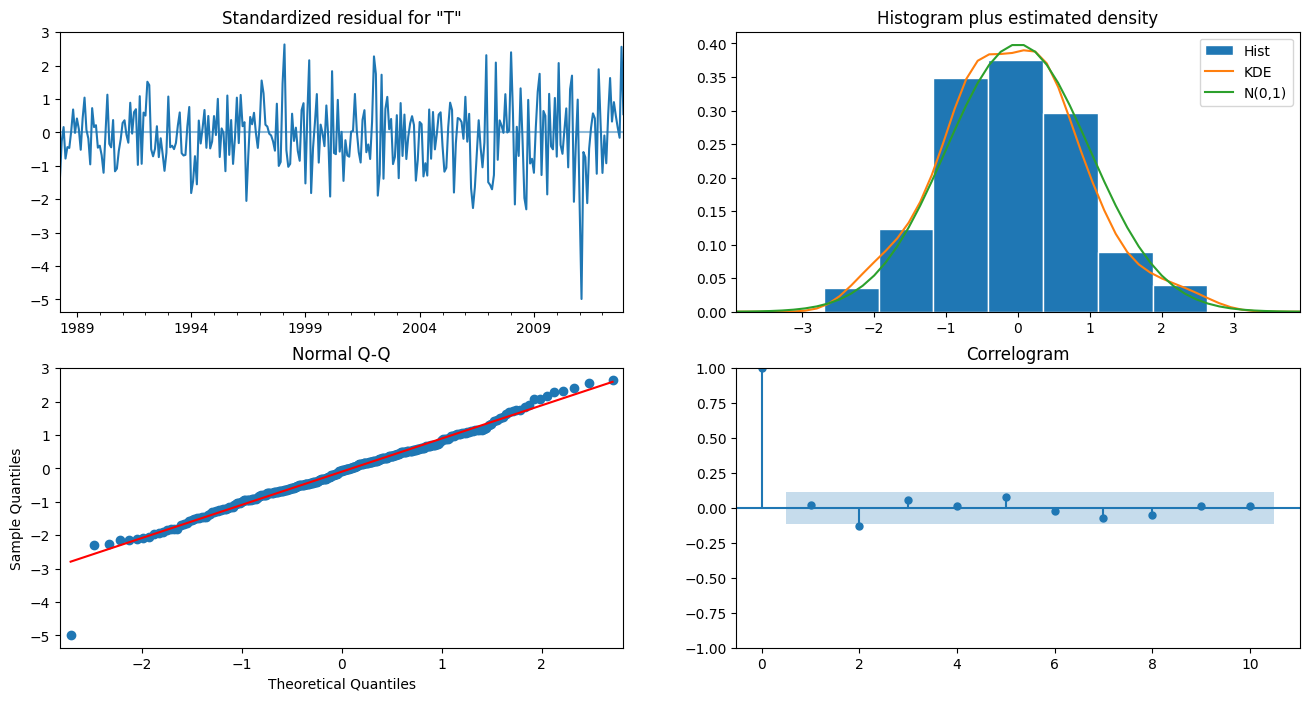

El RMSE de un modelo SARIMA con season_length=52 y dynamic = False es 1288.78


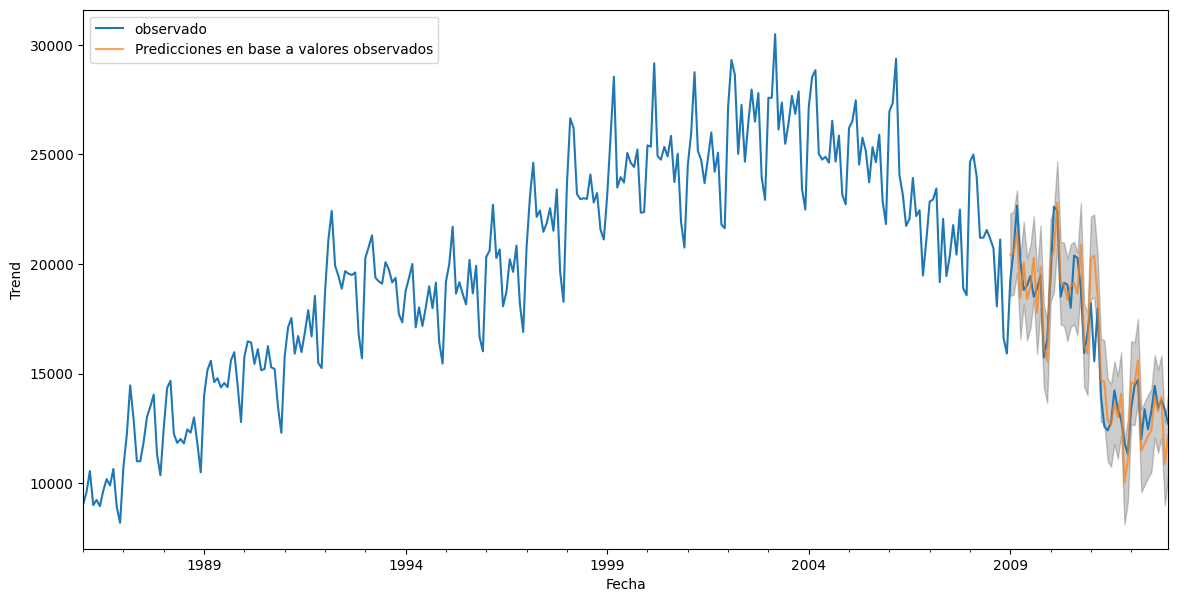

El RMSE de un modelo SARIMA con season_length=52 y dynamic = True es 2610.88


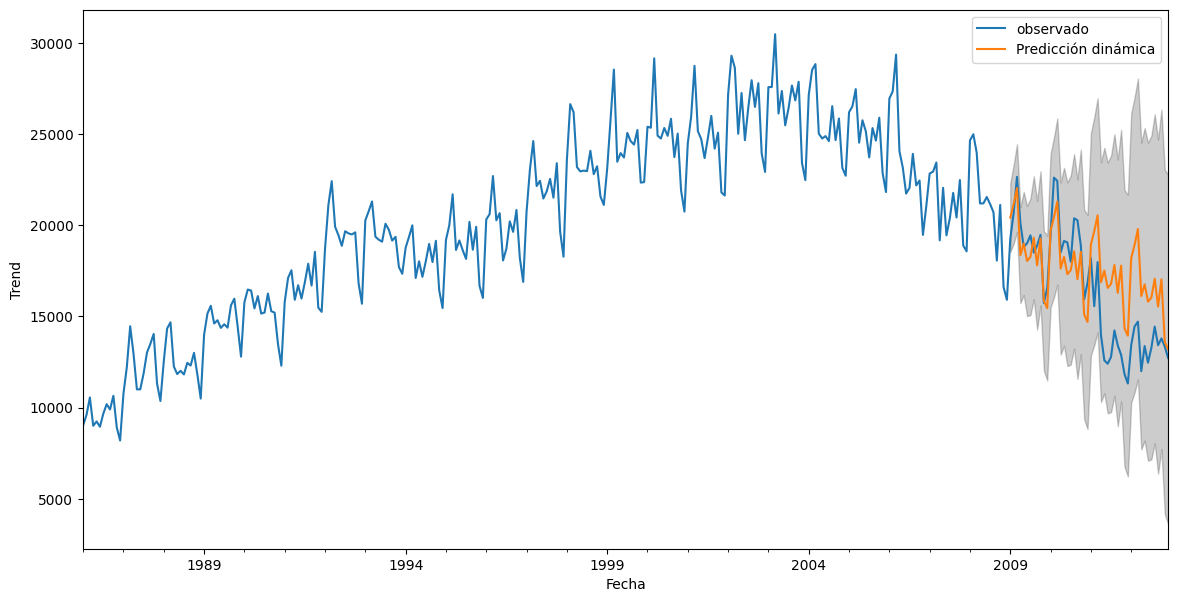

In [19]:
model = sarima_eva(df["Total"],(0, 1, 1),(1, 1, 1, 12),52,predict_date,data_to_test)

Observamos que el modelo no dinámico funciona mejor con estos datos.